In [3]:
from cobra.io import read_sbml_model
model = read_sbml_model('iML1515.xml')

In [4]:
for reaction in model.metabolites.gam_c.reactions:
    print(reaction.id, reaction, reaction.name)

MC6PH MC6PH: h2o_c + mchtbs6p_c --> acgam6p_c + gam_c Monoacetylchitobiose-6-phosphate hydrolase


In [5]:
print(model.objective)

Maximize
1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685


In [7]:
model.medium

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [8]:
model.reactions.EX_chtbs_e.lower_bound = -1000.0
model.reactions.EX_chtbs_e.upper_bound = 1000.0

In [10]:
medium = model.medium
with model:
    medium['EX_chtbs_e'] = 1000
    model.medium = medium
    # model.objective = model.reactions.BIOMASS_Ec_iML1515_core_75p37M
    model.objective = model.reactions.MC6PH
    model.objective = {
                      model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.2,
                      }
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = model.optimize().objective_value
    model.add_boundary(model.metabolites.gam_c, type='demand')
    solution = model.optimize()
    print(solution.fluxes[solution.fluxes != 0])
    print(solution.fluxes["MC6PH"])
    print(solution.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])

SHK3Dr                              9.397445
DHORTS                             -8.156580
OMPDC                               8.156580
G5SD                                5.450665
CS                                506.489716
                                     ...    
4HTHRK                              0.016496
BIOMASS_Ec_iML1515_core_75p37M     24.657508
OPHHXy                              0.005499
MC6PH                             519.654393
DM_gam_c                          519.654393
Name: fluxes, Length: 450, dtype: float64
519.6543926138628
24.657507602392037
DM_gam_c: gam_c --> 


In [12]:
model.genes.get_by_id("b4025")

Gene identifier,b4025
Name,pgi
Memory address,0x1cf214cf850
Functional,True
In 1 reaction(s),PGI


In [13]:
model.reactions.PGI

Reaction identifier,PGI
Name,Glucose-6-phosphate isomerase
Memory address,0x1cf218e08e0
Stoichiometry,g6p_c <=> f6p_c D-Glucose 6-phosphate <=> D-Fructose 6-phosphate
GPR,b4025
Lower bound,-1000.0
Upper bound,1000.0


In [14]:
model.slim_optimize()
model.reactions.PGI.flux

7.644633780205897

In [16]:
model.slim_optimize()
model.reactions.GF6PTA.flux

0.08286571279677578

In [17]:
model.genes.get_by_id("b0677")

Gene identifier,b0677
Name,nagA
Memory address,0x1cf2154d5b0
Functional,True
In 1 reaction(s),AGDC


In [18]:
model.reactions.AGDC

Reaction identifier,AGDC
Name,N-acetylglucosamine-6-phosphate deacetylase
Memory address,0x1cf21b09e20
Stoichiometry,acgam6p_c + h2o_c --> ac_c + gam6p_c N-Acetyl-D-glucosamine 6-phosphate + H2O H2O --> Acetate + D-Glucosamine 6-phosphate
GPR,b0677
Lower bound,0.0
Upper bound,1000.0


In [19]:
model.genes.get_by_id("b0679")

Gene identifier,b0679
Name,nagE
Memory address,0x1cf215c8640
Functional,True
In 1 reaction(s),ACGAptspp


In [20]:
model.reactions.ACGAptspp.genes

frozenset({<Gene b0679 at 0x1cf215c8640>,
           <Gene b1101 at 0x1cf215c8580>,
           <Gene b2415 at 0x1cf2151cc10>,
           <Gene b2416 at 0x1cf2151cd30>,
           <Gene b2417 at 0x1cf215af8b0>})

In [21]:
for reaction in model.metabolites.acgam6p_c.reactions:
    print(reaction.id, reaction, reaction.name)

AGDC AGDC: acgam6p_c + h2o_c --> ac_c + gam6p_c N-acetylglucosamine-6-phosphate deacetylase
AMANAPEr AMANAPEr: acmanap_c <=> acgam6p_c N-acetylmannosamine 6-phosphate epimerase
ACGAptspp ACGAptspp: acgam_p + pep_c --> acgam6p_c + pyr_c N-Acetyl-D-glucosamine transport via PEP:Pyr PTS  (periplasm)
MC6PH MC6PH: h2o_c + mchtbs6p_c --> acgam6p_c + gam_c Monoacetylchitobiose-6-phosphate hydrolase
ACM6PH ACM6PH: acmum6p_c + h2o_c --> acgam6p_c + lac__D_c N-acetylmuramate 6-phosphate hydrolase
ACGAMK ACGAMK: acgam_c + atp_c --> acgam6p_c + adp_c + h_c N-acetylglucosamine kinase


In [22]:
genes = ["b0677", "b0678", "b0679", "b1817", "b1818", "b1819"]
essentiality = {}
for gene in genes:
    with model:
        model.genes.get_by_id(gene).knock_out()
        essentiality[gene] = model.slim_optimize(error_value=0.)

<AxesSubplot: ylabel='Frequency'>

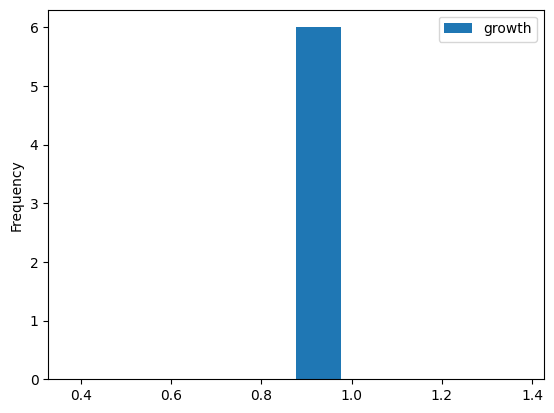

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame.from_dict(essentiality, orient='index')
df = df.rename(columns={0: 'growth'})
df = df.sort_values('growth')
df.plot.hist()

In [25]:
from cobra import Reaction
medium = model.medium
fluxes = []
growth = []
with model:
    for i in range(1,15,):
        medium['EX_chtbs_e'] = 0
        model.medium = medium
        model.genes.get_by_id("b0677").knock_out()
        model.genes.get_by_id("b0678").knock_out()
        model.genes.get_by_id("b0679").knock_out()
        model.genes.get_by_id("b1817").knock_out()
        model.genes.get_by_id("b1818").knock_out()
        model.genes.get_by_id("b1819").knock_out()
        model.genes.get_by_id("b1101").knock_out()
        model.genes.get_by_id("b2415").knock_out()
        model.genes.get_by_id("b2416").knock_out()
        model.genes.get_by_id("b2417").knock_out()
        # gene integration
        reaction = Reaction("ExRe1")
        reaction.name = "GlcNAc-6-P N-Acetyltransferase"
        reaction.lower_bound = 0
        reaction.upper_bound = 1000

        reaction.add_metabolites({
            model.metabolites.get_by_id("ac_c"): -1.0,
            model.metabolites.get_by_id("gam6p_c"): -1.0,
            model.metabolites.get_by_id("acgam6p_c"): 1.0,
            model.metabolites.get_by_id("h2o_c"): 1.0
        })
        model.add_reactions([reaction])
        reaction = Reaction("ExRe2")
        reaction.name = "GlcNAc-6-P phosphatase"
        reaction.lower_bound = 0
        reaction.upper_bound = 1000

        reaction.add_metabolites({
            model.metabolites.get_by_id("acgam6p_c"): -1.0,
            model.metabolites.get_by_id("pyr_c"): -1.0,
            model.metabolites.get_by_id("pep_c"): 1.0,
            model.metabolites.get_by_id("acgam_p"): 1.0
        })
        model.add_reactions([reaction])
        
        model.objective = model.reactions.BIOMASS_Ec_iML1515_core_75p37M
        model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = model.optimize().objective_value / i
        growth.append(model.optimize().objective_value / i)
        model.objective = model.reactions.ExRe2
        solution = model.optimize()
        print(solution.fluxes[solution.fluxes != 0])
        print(solution.fluxes["GF6PTA"])
        print(solution.fluxes["G6PDA"])
        print(solution.fluxes["ACGAptspp"])
        print(solution.fluxes["ExRe1"])
        print(solution.fluxes["ExRe2"])
        print(solution.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])
        fluxes.append(solution.fluxes["ExRe2"])

Ignoring reaction 'ExRe1' since it already exists.
Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.


SHK3Dr                            3.306562e-01
DHORTS                           -2.869954e-01
OMPDC                             2.869954e-01
G5SD                              1.917858e-01
CS                                7.096230e+00
                                      ...     
THZPSN3                           1.934732e-04
PAI2T                             3.886817e-04
4HTHRK                            5.804197e-04
BIOMASS_Ec_iML1515_core_75p37M    8.675930e-01
ExRe2                             4.349576e-13
Name: fluxes, Length: 441, dtype: float64
0.08197712961975512
0.0
0.0
0.0
4.349576254725207e-13
0.8675930236571856
SHK3Dr                            0.165328
DHORTS                           -0.143498
OMPDC                             0.143498
G5SD                              0.095893
CS                                2.472461
                                    ...   
PAI2T                             0.000194
4HTHRK                            0.000290
BIOMASS_Ec_iML1515_core_

Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.
Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.


SHK3Dr                            0.110219
DHORTS                           -0.095665
OMPDC                             0.095665
G5SD                              0.063929
CS                                0.931205
                                    ...   
PAI2T                             0.000130
4HTHRK                            0.000193
BIOMASS_Ec_iML1515_core_75p37M    0.289198
ExRe1                             4.842835
ExRe2                             4.842835
Name: fluxes, Length: 441, dtype: float64
4.8701603555426445
0.0
0.0
4.842834645669538
4.842834645669538
0.2891976745523952
SHK3Dr                            0.082664
DHORTS                           -0.071749
OMPDC                             0.071749
G5SD                              0.047946
CS                                0.233207
                                    ...   
PAI2T                             0.000097
4HTHRK                            0.000145
BIOMASS_Ec_iML1515_core_75p37M    0.216898
ExRe1           

Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.
Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.


SHK3Dr                            0.066131
DHORTS                           -0.057399
OMPDC                             0.057399
G5SD                              0.038357
CS                                0.186566
                                    ...   
PAI2T                             0.000078
4HTHRK                            0.000116
BIOMASS_Ec_iML1515_core_75p37M    0.173519
ExRe1                             5.794691
ExRe2                             5.794691
Name: fluxes, Length: 442, dtype: float64
5.81108655131901
0.0
0.0
5.794691125395146
5.794691125395146
0.17351860473143632
SHK3Dr                            0.055109
DHORTS                           -0.047833
OMPDC                             0.047833
G5SD                              0.031964
CS                                0.155472
                                    ...   
PAI2T                             0.000065
4HTHRK                            0.000097
BIOMASS_Ec_iML1515_core_75p37M    0.144599
ExRe1            

Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.
Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.


NDPK5                            -0.471930
SHK3Dr                            0.047237
DHORTS                           -0.040999
OMPDC                             0.040999
G5SD                              0.027398
                                    ...   
PAI2T                             0.000056
4HTHRK                            0.000083
BIOMASS_Ec_iML1515_core_75p37M    0.123942
ExRe1                             6.166132
ExRe2                             6.166132
Name: fluxes, Length: 445, dtype: float64
6.1778425670843715
0.0
0.0
6.166131548567326
6.166131548567326
0.12394186052245429
NDPK5                            -0.884651
SHK3Dr                            0.041332
DHORTS                           -0.035874
OMPDC                             0.035874
G5SD                              0.023973
                                    ...   
PAI2T                             0.000049
4HTHRK                            0.000073
BIOMASS_Ec_iML1515_core_75p37M    0.108449
ExRe1          

Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.
Ignoring reaction 'ExRe2' since it already exists.


SHK3Dr                            0.036740
NDPK8                            -1.205657
DHORTS                           -0.031888
OMPDC                             0.031888
G5SD                              0.021310
                                    ...   
PAI2T                             0.000043
4HTHRK                            0.000064
BIOMASS_Ec_iML1515_core_75p37M    0.096399
ExRe1                             6.370539
ExRe2                             6.370539
Name: fluxes, Length: 443, dtype: float64
6.379647963471639
0.0
0.0
6.370539393513937
6.370539393513937
0.0963992248507984
SHK3Dr                            0.033066
NDPK8                            -1.462462
DHORTS                           -0.028700
OMPDC                             0.028700
G5SD                              0.019179
                                    ...   
PAI2T                             0.000039
4HTHRK                            0.000058
BIOMASS_Ec_iML1515_core_75p37M    0.086759
ExRe1            

Ignoring reaction 'ExRe1' since it already exists.
Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.
Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.


SHK3Dr                            0.030060
NDPK8                            -1.672574
DHORTS                           -0.026090
OMPDC                             0.026090
G5SD                              0.017435
                                    ...   
PAI2T                             0.000035
4HTHRK                            0.000053
BIOMASS_Ec_iML1515_core_75p37M    0.078872
ExRe1                             6.500617
ExRe2                             6.500617
Name: fluxes, Length: 443, dtype: float64
6.508069579354899
0.0
0.0
6.50061711302587
6.50061711302587
0.07887209305974414
NDPK5                            -1.847668
SHK3Dr                            0.027555
DHORTS                           -0.023916
OMPDC                             0.023916
G5SD                              0.015982
                                    ...   
PAI2T                             0.000032
4HTHRK                            0.000048
BIOMASS_Ec_iML1515_core_75p37M    0.072299
ExRe1             

Ignoring reaction 'ExRe2' since it already exists.
Ignoring reaction 'ExRe1' since it already exists.
Ignoring reaction 'ExRe2' since it already exists.


NDPK5                            -1.995825
SHK3Dr                            0.025435
DHORTS                           -0.022077
OMPDC                             0.022077
G5SD                              0.014753
                                    ...   
PAI2T                             0.000030
4HTHRK                            0.000045
BIOMASS_Ec_iML1515_core_75p37M    0.066738
ExRe1                             6.590671
ExRe2                             6.590671
Name: fluxes, Length: 446, dtype: float64
6.596976851889511
0.0
0.0
6.59067091884187
6.59067091884187
0.06673792489670652
NDPK5                            -2.122816
SHK3Dr                            0.023618
DHORTS                           -0.020500
OMPDC                             0.020500
G5SD                              0.013699
                                    ...   
PAI2T                             0.000028
4HTHRK                            0.000041
BIOMASS_Ec_iML1515_core_75p37M    0.061971
ExRe1             

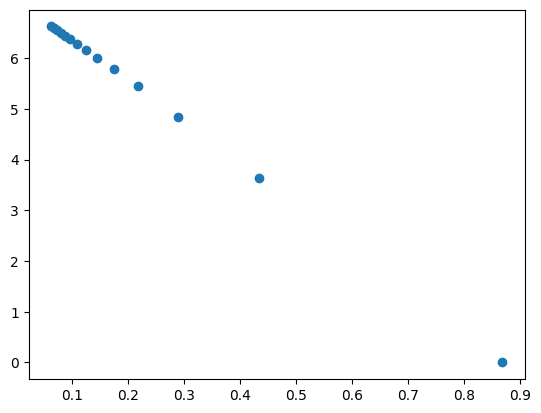

In [26]:
plt.plot(growth, fluxes)
plt.xlabel('Growth [$h^{-1}$]')
plt.ylabel('Product flux [$mmol gDW^{-1} h^{-1}$]')
plt.show()

In [ ]:
from cobra.flux_analysis import moma
moma(model)

# Predict gene knockout strategies

In [99]:
from cameo.strain_design.heuristic.evolutionary_based import OptGene

In [ ]:
with model:
    # gene integration
    reaction = Reaction("ExRe1")
    reaction.name = "GlcNAc-6-P N-Acetyltransferase"
    reaction.lower_bound = 0
    reaction.upper_bound = 1000

    reaction.add_metabolites({
        model.metabolites.get_by_id("ac_c"): -1.0,
        model.metabolites.get_by_id("gam6p_c"): -1.0,
        model.metabolites.get_by_id("acgam6p_c"): 1.0,
        model.metabolites.get_by_id("h2o_c"): 1.0
    })
    model.add_reactions([reaction])
    reaction = Reaction("ExRe2")
    reaction.name = "GlcNAc-6-P phosphatase"
    reaction.lower_bound = 0
    reaction.upper_bound = 1000

    reaction.add_metabolites({
        model.metabolites.get_by_id("acgam6p_c"): -1.0,
        model.metabolites.get_by_id("pyr_c"): -1.0,
        model.metabolites.get_by_id("pep_c"): 1.0,
        model.metabolites.get_by_id("acgam_p"): 1.0
    })
    model.add_reactions([reaction])

    optgene = OptGene(model)
    result = optgene.run(target=model.reactions.EX_succ_e, 
                 biomass=model.reactions.BIOMASS_Ec_iML1515_core_75p37M,
                 substrate=model.metabolites.glc__D_e,
                 max_evaluations=20000, population_size=200, max_knockouts=5,
                 plot=False, growth_coupled=True)
    result

Starting optimization at Thu, 17 Nov 2022 16:08:36


HBox()

## Using networkx to analyze the network

In [45]:
from cobra.flux_analysis import moma

In [39]:
model

Name,iML1515
Memory address,0x01cf4e1eea60
Number of metabolites,1877
Number of reactions,2712
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


In [27]:
from cobra.util import create_stoichiometric_matrix
S = create_stoichiometric_matrix(model)

In [38]:
S

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
import numpy as np
S_hat = np.where(S==0, S, 1)
A_v = S_hat.T @ S_hat
A_x = S_hat @ S_hat.T

In [47]:
import networkx as nx

In [33]:
compound_centric_network = nx.from_numpy_matrix(A_x)

In [34]:
mapping = dict(zip(range(0, len(model.metabolites)), model.metabolites))
compound_centric_network = nx.relabel_nodes(compound_centric_network, mapping)

In [35]:
metabolite_degrees = compound_centric_network.degree()

In [36]:
sorted_metabolite_degrees = sorted(metabolite_degrees, key=lambda item: item[1], reverse=True)
sorted_metabolite_degrees[0:10]

[(<Metabolite h_c at 0x1cf20f20b80>, 1216),
 (<Metabolite h2o_c at 0x1cf211d55e0>, 864),
 (<Metabolite atp_c at 0x1cf210684c0>, 610),
 (<Metabolite pi_c at 0x1cf2101c4c0>, 557),
 (<Metabolite adp_c at 0x1cf20fe8610>, 525),
 (<Metabolite h_p at 0x1cf20f9a280>, 479),
 (<Metabolite ppi_c at 0x1cf21103160>, 302),
 (<Metabolite nad_c at 0x1cf20fb5fd0>, 298),
 (<Metabolite nadp_c at 0x1cf21103280>, 294),
 (<Metabolite nadph_c at 0x1cf212a67f0>, 294)]

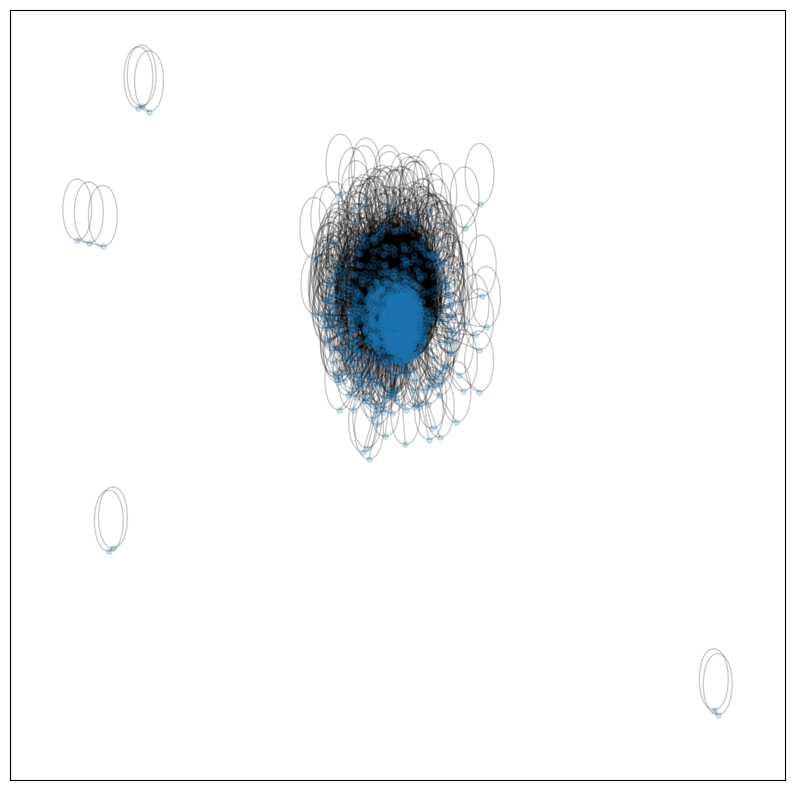

In [37]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(compound_centric_network, node_size=15, alpha=.2, with_labels=False)

In [92]:
a=list(compound_centric_network.nodes)[565]
b=list(compound_centric_network.nodes)[420]
for i in range(len(list(compound_centric_network.nodes))):
    print(i, list(compound_centric_network.nodes)[i])

0 octapb_c
1 cysi__L_e
2 dhap_c
3 prbatp_c
4 10fthf_c
5 btal_c
6 6pgg_c
7 co2_e
8 akg_e
9 gsn_e
10 pydx5p_c
11 3dhgulnp_c
12 g3ps_c
13 adphep_LD_c
14 lyx__L_c
15 din_p
16 2pg_c
17 ptrc_p
18 malt_p
19 pppn_p
20 arbtn_p
21 hphhlipa_c
22 phphhlipa_c
23 13dpg_c
24 murein3px4p_p
25 34dhpac_e
26 1odec11eg3p_c
27 12dgr181_p
28 anhgm_e
29 prbamp_c
30 dsbdrd_c
31 cu2_p
32 sla_c
33 14glucan_p
34 grdp_c
35 ribflv_p
36 dms_e
37 pgp141_c
38 cysi__L_c
39 fpram_c
40 f1p_c
41 dsbard_p
42 thr__L_c
43 dcyt_p
44 2ddglcn_c
45 fum_p
46 galctn__L_e
47 btn_e
48 pydxn_p
49 ocdcea_e
50 preq0_c
51 tyr__L_p
52 dtdp4d6dg_c
53 acmum_e
54 man_p
55 adocbl_e
56 iscu_2fe2s_c
57 frulysp_c
58 dump_p
59 novbcn_e
60 feenter_e
61 eca4und_p
62 gg4abut_c
63 flxr_c
64 pa160_c
65 lcts_c
66 arbtn_e
67 cdpdhdec9eg_c
68 aso3_c
69 progly_c
70 3ohdcoa_c
71 clpn161_p
72 1ddecg3p_p
73 gln__L_e
74 cpgn_un_e
75 ca2_p
76 tre_e
77 iscssh_c
78 glyald_c
79 alaala_e
80 novbcn_p
81 3ohexACP_c
82 g3pg_c
83 rpntp_c
84 adocbl_c
85 3ocddec5eACP_

In [96]:
print(nx.shortest_path(compound_centric_network, source=a, target=b))

[<Metabolite glc__D_c at 0x1cf2104fa60>, <Metabolite h_c at 0x1cf20f20b80>, <Metabolite uacgam_c at 0x1cf212730a0>, <Metabolite puacgam_c at 0x1cf21103fd0>, <Metabolite puacgam_p at 0x1cf20fe8940>]


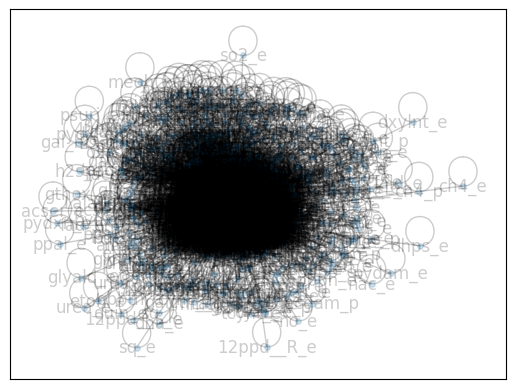

In [63]:
A = (compound_centric_network.subgraph(c) for c in nx.connected_components(compound_centric_network))
A = list(A)[0]
nx.draw_networkx(A, node_size=15, alpha=.2, with_labels=True)